## Deep Learning with PyTorch : Neural Style Transfer

![](https://archive.org/download/deep-learning-with-py-torch/Deep%20Learning%20with%20PyTorch.png)

In [1]:
!pip install torch torchvision

In [2]:
!git clone https://github.com/parth1620/Project-NST.git

fatal: destination path 'Project-NST' already exists and is not an empty directory.


## 1: Loading VGG Pretrained Model

In [3]:
import torch
from torchvision import models
vgg = models.vgg19(pretrained = True)

vgg = vgg.features # remove the classifier part

for p in vgg.parameters(): # freeze layers
  p.requires_grad_(False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## 2: Preprocess and Deprocess image

Torchvision models page : https://pytorch.org/docs/stable/torchvision/models.html

In [6]:
from PIL import Image
from torchvision import transforms as T

def preprocess(img_path, max_size=500):
  image = Image.open(img_path).convert('RGB')

  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)

  img_transforms = T.Compose([
      T.Resize(size),
      T.ToTensor(),
      T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
  ])

  image = img_transforms(image)

  image = image.unsqueeze(0) # add dimention
  return image

In [7]:
content_p = preprocess('/content/Project-NST/content11.jpg').to(device)
style_p = preprocess('/content/Project-NST/style12.jpg').to(device)

print(content_p.shape, style_p.shape)

torch.Size([1, 3, 259, 345]) torch.Size([1, 3, 625, 500])


In [8]:
import numpy as np
import matplotlib.pyplot as plt

def deprocess(tensor):
  image = tensor.to('cpu')
  image = image.numpy()
  image = image.squeeze(0)
  image = image.transpose(1,2,0)
  image = image * np.array([0.229, 0.224, 0.225]) + np.array([[0.485, 0.456, 0.406]])

  return image

In [9]:
content_d = deprocess(content_p)
style_d = deprocess(style_p)

print(content_d.shape, style_d.shape)

(259, 345, 3) (625, 500, 3)


## 3: Get content,style features and create gram matrix

In [10]:
def get_features(image, model):
  layers = { # features layer based on vgg's paper
      '0' : 'conv1_1',
      '5' : 'conv2_1',
      '10' : 'conv3_1',
      '19' : 'conv4_1',
      '21' : 'conv4_2', # content_feature
      '28' : 'conv5_1',
  }

  features = {}

  x = image
  for name, l in model._modules.items():
    x = l(x)
    if name in layers:
      features[layers[name]] = x
  return features


In [11]:
content_f = get_features(content_p, vgg)
style_f = get_features(style_p, vgg)

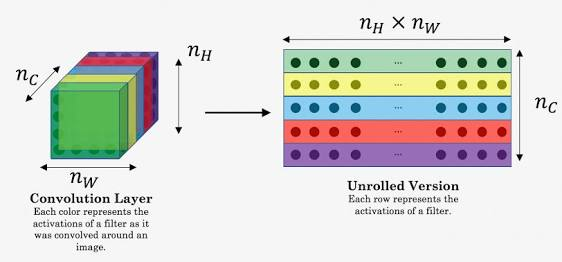

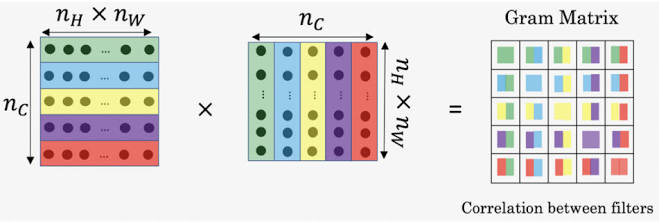

In [12]:
def gram_matrix(tensor):
  b, c, h, w = tensor.size()
  tensor = tensor.view(c, h*w)
  gram = torch.mm(tensor, tensor.t())
  return gram

In [13]:
style_grams = {
    layer: gram_matrix(style_f[layer]) for layer in style_f
}

## 4: Creating Style and Content loss function

In [14]:
def content_loss(target_conv4_2, content_conv4_2):
  loss = torch.mean((target_conv4_2 - content_conv4_2) ** 2)
  return loss

In [15]:
style_weights = {
    'conv1_1' : 1.0,
    'conv2_1' : 0.75,
    'conv3_1' : 0.2,
    'conv4_1' : 0.2,
    'conv5_1' : 0.2
}

In [16]:
def style_loss(style_weights, target_features, style_grams):
  loss = 0

  for layer in style_weights:
    target_f = target_features[layer]
    target_gram = gram_matrix(target_f)
    style_gram = style_grams[layer]
    b, c, h, w = target_f.shape
    layer_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)
    loss += layer_loss / (c*h*w)

  return loss

In [17]:
target = content_p.clone().requires_grad_(True).to(device)
target_f = get_features(target, vgg)
print(content_loss(target_f['conv4_2'], content_f['conv4_2']))
print(style_loss(style_weights, target_f, style_grams))

tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1765.7550, device='cuda:0', grad_fn=<AddBackward0>)


## 5: Training loop

In [18]:
from torch import optim
optimizer = optim.Adam([target], lr=0.003)

alpha = 1.
beta = 1e5
epochs = 3000
show_every = 500

In [19]:
def total_loss(c_loss, s_loss, alpha, beta):
  loss = alpha * c_loss + beta * s_loss
  return loss

In [20]:
results = []

for i in range(epochs):
  target_f = get_features(target, vgg)
  c_loss = content_loss(target_f['conv4_2'], content_f['conv4_2'])
  s_loss = style_loss(style_weights, target_f, style_grams)
  t_loss = total_loss(c_loss, s_loss, alpha, beta)

  optimizer.zero_grad()
  t_loss.backward()
  optimizer.step()

  if i % show_every == 0:
    print(f"Total loss at Epoch {i}: {t_loss}")
    results.append(deprocess(target.detach()))

Total loss at Epoch 0: 176575504.0
Total loss at Epoch 500: 27061606.0
Total loss at Epoch 1000: 15213372.0
Total loss at Epoch 1500: 11746659.0
Total loss at Epoch 2000: 9687782.0
Total loss at Epoch 2500: 8303181.5


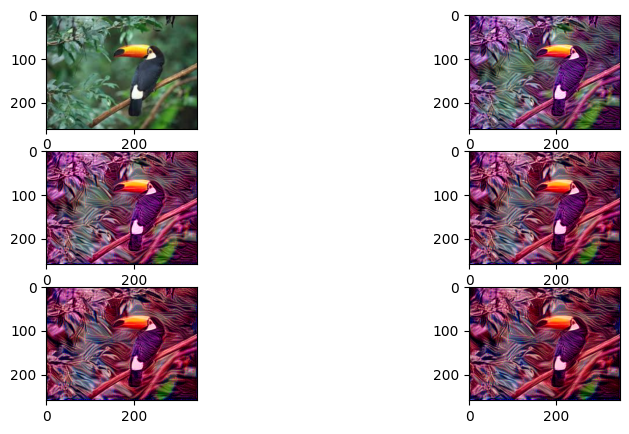

In [21]:
plt.figure(figsize = (10, 5))
for i in range (len(results)):
  plt.subplot(3, 2, i+1)
  plt.imshow(results[i])
plt.show()

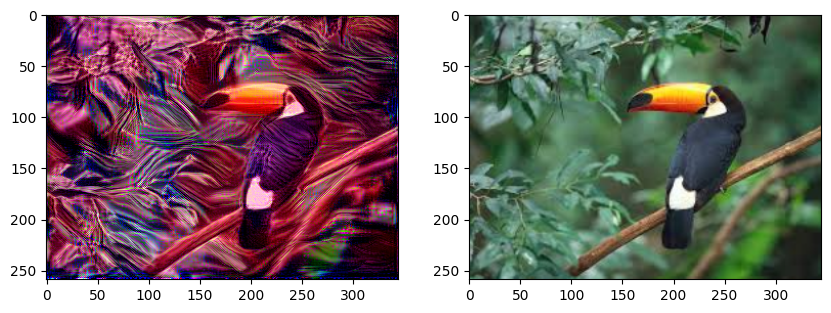

In [22]:
target_copy = deprocess(target.detach())
content_copy = deprocess(content_p)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.imshow(target_copy)
ax2.imshow(content_copy)